In [1]:
!pip install -q tensorflow Pillow matplotlib seaborn numpy pandas

In [2]:
# !pip install -q cudf-cu11 --extra-index-url=https://pypi.nvidia.com

In [3]:
import os
import re
import string
from pathlib import Path
from shutil import copyfileobj
from urllib.request import urlopen

# import cudf # cudf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import json
from random import shuffle
import pandas as pd
import datetime

import zipfile

print(f"TF version: {tf.__version__}")

TF version: 2.14.0


In [4]:
# %load_ext cudf.pandas

In [5]:
def archive(dir: Path):
    with zipfile.ZipFile(f"{dir}.zip", "w", zipfile.ZIP_DEFLATED) as zip_file:
        for entry in dir.rglob("*"):
            zip_file.write(entry, entry.relative_to(dir))


def unarchive(file: Path):
    with zipfile.ZipFile(file, "r") as zip_file:
        zip_file.extractall(file.with_suffix(""))

In [6]:
def download_file(url, dataset_file_path):
    path = Path(dataset_file_path)
    os.makedirs(path.parent, exist_ok=True)
    if not path.exists():
        print(f"Downloading {path}")
        with urlopen(url) as fsrc, open(path, "wb") as fdst:
            copyfileobj(fsrc, fdst)
    else:
        print(f"File {path} exists")

In [7]:
dataset_path = "tmp/time_series_prediction"
batch_size = 2048
sequence_stride = 1

In [8]:
download_file("https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
              f"{dataset_path}.zip")

File tmp/time_series_prediction.zip exists


In [9]:
unarchive(Path(f"{dataset_path}.zip"))

In [10]:
df = pd.read_csv(f"{dataset_path}/jena_climate_2009_2016.csv", delimiter=",", index_col=[0], dtype=str)

In [11]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.00
31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.30
31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.20


In [12]:
df.index = pd.to_datetime(df.index, format="%d.%m.%Y %H:%M:%S")

In [13]:
df = df.apply(pd.to_numeric)

In [14]:
def deduplicate(df):
  return df[~df.index.duplicated(keep="first")]

df = deduplicate(df)

In [15]:
sample_period_s = df.index[1].timestamp() - df.index[0].timestamp()
sample_period_s

600.0

In [16]:
def seconds_to_hms(seconds):
  import datetime
  from datetime import datetime as dt
  return str(datetime.timedelta(seconds=seconds))

In [17]:
# Uneven data points
[(index, i, seconds_to_hms(diff_s)) for index, i, diff_s in zip(df.index, range(df.size), np.diff(df.index.map(lambda x: x.timestamp()))) if diff_s != sample_period_s]

[(Timestamp('2009-10-08 09:40:00'), 40377, '0:30:00'),
 (Timestamp('2013-05-16 08:50:00'), 229874, '0:20:00'),
 (Timestamp('2014-07-30 08:00:00'), 293228, '0:20:00'),
 (Timestamp('2014-09-24 17:00:00'), 301345, '16:00:00'),
 (Timestamp('2016-10-25 10:30:00'), 410939, '3 days, 2:20:00')]

In [18]:
# os.makedirs(f"{dataset_path}/processed", exist_ok=True)
# df.to_csv(f"{dataset_path}/processed/jena_climate_2009_2016_processed.csv")
# archive(Path(f"{dataset_path}/processed"))

In [19]:
hour_s = 60 * 60
day_s = 24 * hour_s
week_s = 7 * day_s
year_s = (365 * 3 + 366) / 4.0 * day_s
month_s = year_s / 12
year_months = year_s / month_s
year_weeks = year_s / week_s
year_days = year_s / day_s
year_hours = year_s / hour_s

In [20]:
samples_per_year = year_s / sample_period_s
dataset_years = len(df) / samples_per_year
dataset_years

7.989657008137501

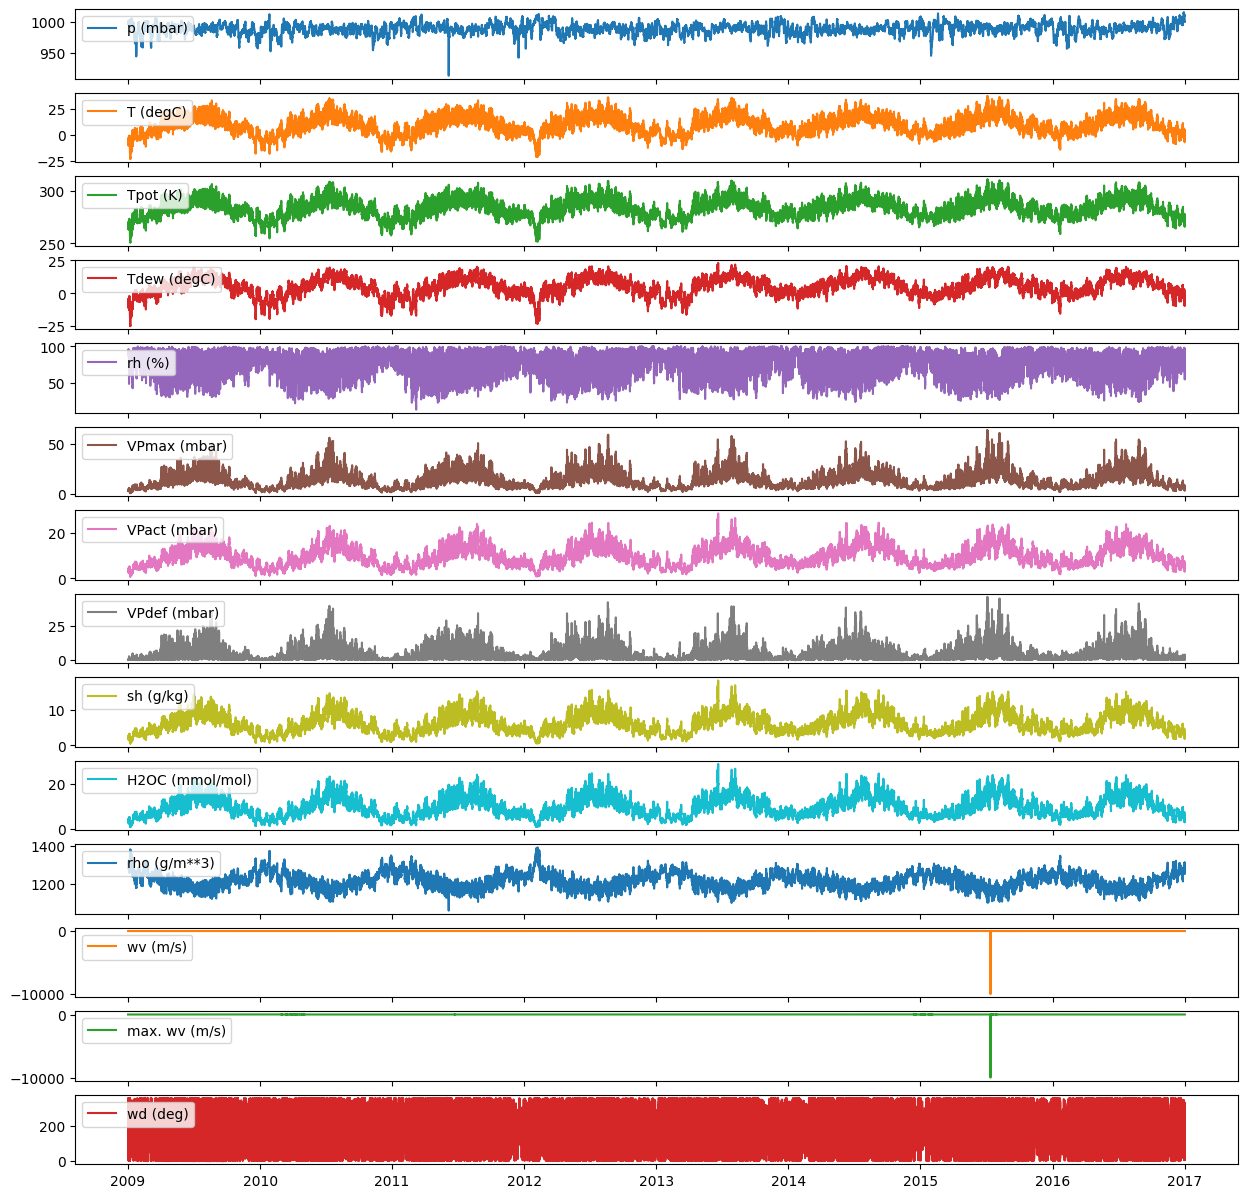

In [21]:
def plot_df(df):
  colors = plt.rcParams["axes.prop_cycle"]()
  f, ax = plt.subplots(nrows=len(df.columns), figsize=(15, 15), sharex=True)
  for index, column in enumerate(df.columns):
    ax[index].plot(df.index, df[column], label=column, color=next(colors)["color"])
    ax[index].legend(loc="upper left")
  _ = plt.show()

plot_df(df)

In [22]:
# def fix_column(column):
#   mean = column.mean()
#   threshold = mean * 100
#   return column.map(lambda x: x if abs(x) <= abs(threshold) else mean)

# for column in df.columns:
#   df[column] = fix_column(df[column])

In [23]:
# def filter_df(df):
#   threshold = df.mean().abs() * 100
#   return df.apply(lambda row: row if all(row.abs() <= threshold) else 0, axis=1)

# df = filter_df(df)

# Faster version

def filter_df(df):
  threshold = df.mean().abs() * 100
  for index, row in df.iterrows():
    for column in df.columns:
      if abs(row[column]) > threshold[column]:
        df.loc[index] = 0

filter_df(df)

In [24]:
df = df[~(df == 0).all(axis=1)]

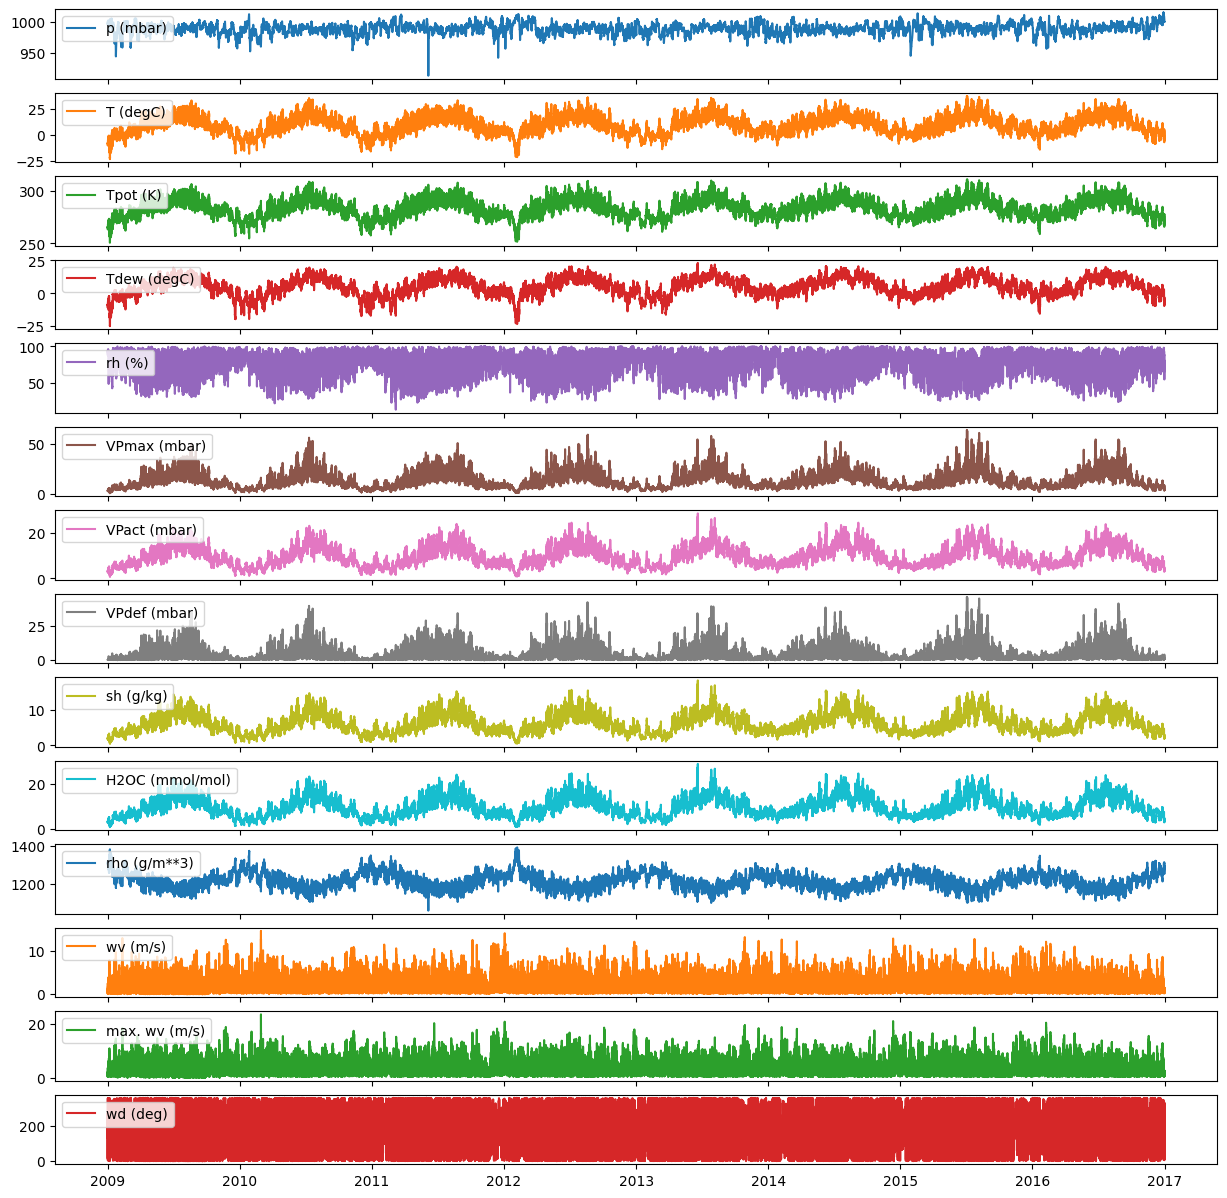

In [25]:
plot_df(df)

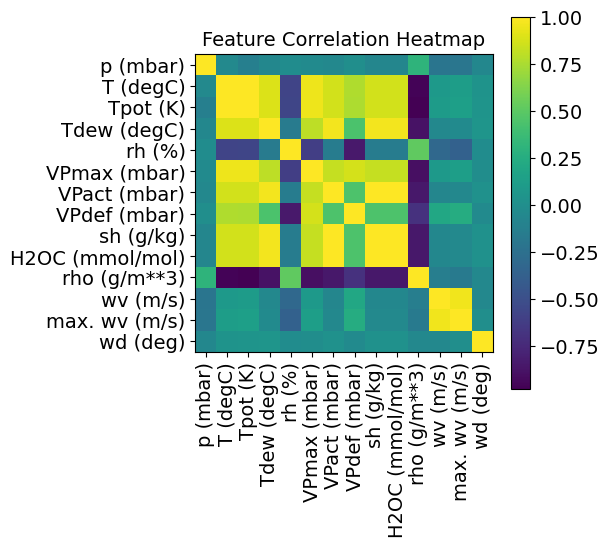

In [26]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [27]:
# Features

In [28]:
df["wd (deg) sin"] = np.sin(df["wd (deg)"] / 180 * np.pi)
df["wd (deg) cos"] = np.cos(df["wd (deg)"] / 180 * np.pi)
df = df.drop("wd (deg)", axis=1)
df["wd x"] = df["wv (m/s)"] * df["wd (deg) cos"]
df["wd y"] = df["wv (m/s)"] * df["wd (deg) sin"]

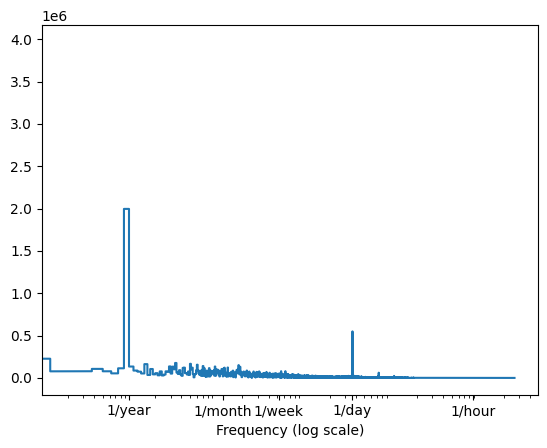

In [29]:
fft = tf.signal.rfft(df["T (degC)"])
f_per_year = np.arange(0, len(fft)) / dataset_years
plt.step(x=f_per_year, y=np.abs(fft))
plt.xscale("log")
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, year_months, year_weeks, year_days, year_hours],
           labels=["1/year", "1/month", "1/week", "1/day", "1/hour"])
plt.xlabel("Frequency (log scale)")
_ = plt

In [30]:
df["day sin"] = np.sin(df.index.map(lambda x: x.timestamp()) * (2 * np.pi / day_s))
df["day cos"] = np.cos(df.index.map(lambda x: x.timestamp()) * (2 * np.pi / day_s))
df["week sin"] = np.sin(df.index.map(lambda x: x.timestamp()) * (2 * np.pi / week_s))
df["week cos"] = np.cos(df.index.map(lambda x: x.timestamp()) * (2 * np.pi / week_s))
df["year sin"] = np.sin(df.index.map(lambda x: x.timestamp()) * (2 * np.pi / year_s))
df["year cos"] = np.cos(df.index.map(lambda x: x.timestamp()) * (2 * np.pi / year_s))
date_features = ["day sin", "day cos", "week sin", "week cos", "year sin", "year cos"]
date_feature_count = len(date_features)

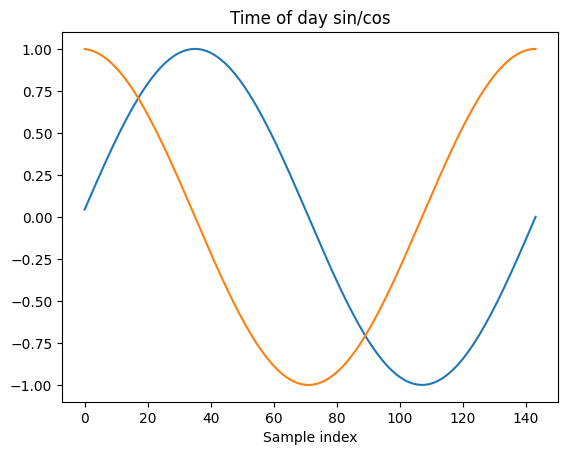

In [31]:
plt.plot(np.array(df["day sin"])[:int(day_s / sample_period_s)])
plt.plot(np.array(df["day cos"])[:int(day_s / sample_period_s)])
plt.xlabel("Sample index")
plt.title("Time of day sin/cos")
_ = plt

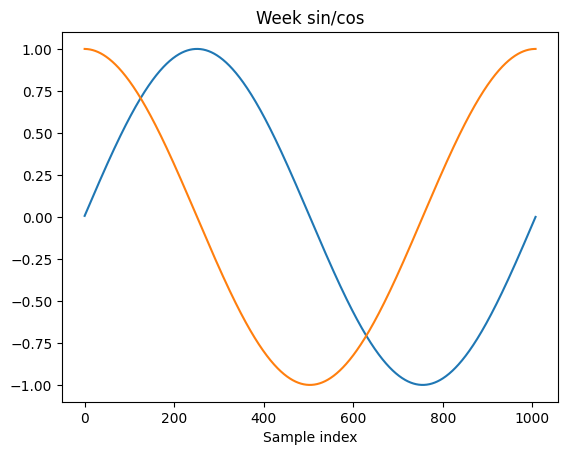

In [32]:
plt.plot(np.array(df["week sin"])[:int(week_s / sample_period_s)])
plt.plot(np.array(df["week cos"])[:int(week_s / sample_period_s)])
plt.xlabel("Sample index")
plt.title("Week sin/cos")
_ = plt

In [33]:
split_size = 0.8
train_df = df[:int(len(df) * split_size)]
val_df = df[len(train_df):]

In [34]:
train_mean = train_df.mean()
train_std = train_df.std()
df = (df - train_mean) / train_std

In [35]:
start_ts = df.index[0]
end_ts = df.index[-1]

for ts in pd.date_range(start_ts, end_ts, freq=f"{sample_period_s}S"):
  if ts not in df.index:
    df.loc[ts] = 0 # A timestep is masked in TF only if all features are 0, so should be ok for cases when only a few features are 0

df = df.sort_index()

assert np.all(np.diff(df.index.map(lambda x: x.timestamp())) == sample_period_s)

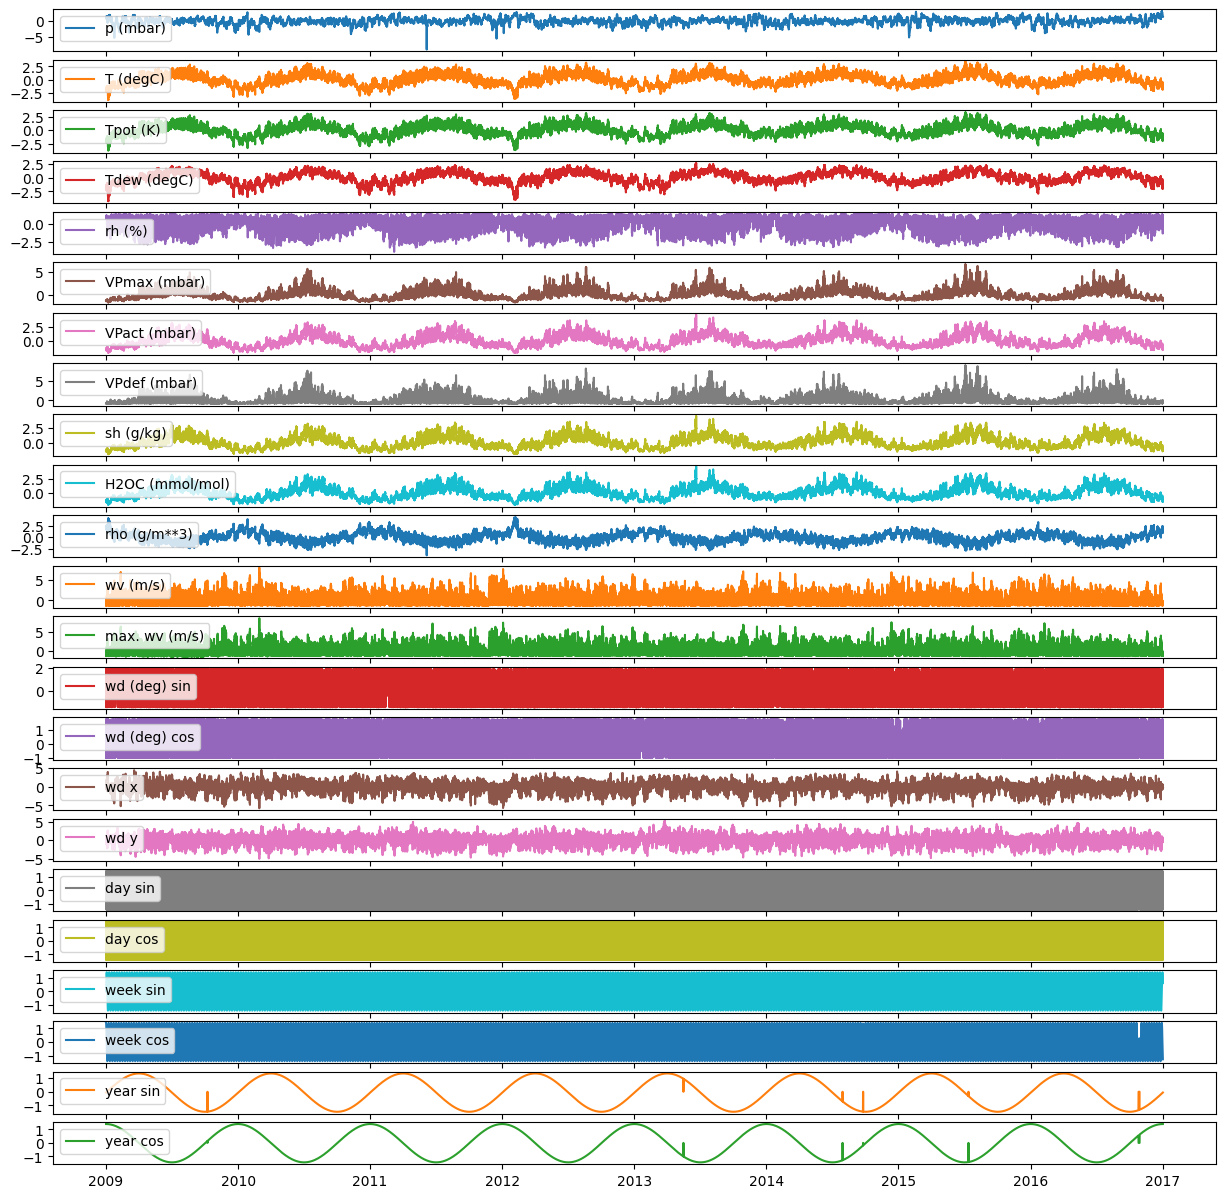

In [36]:
plot_df(df)

In [37]:
train_df = df[:int(len(df) * split_size)]
val_df = df[len(train_df):]

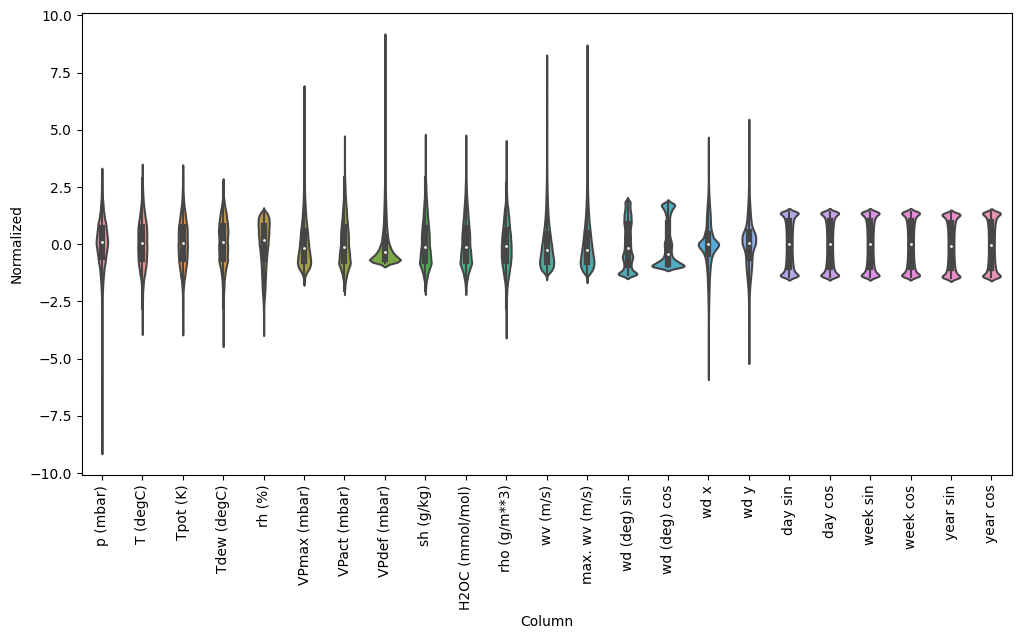

In [38]:
df_normalized = df.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_normalized)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [39]:
list(tf.keras.utils.timeseries_dataset_from_array(
    [1, 2, 3, 4, 5, 6, 7],
    targets=None,
    sequence_length=4,
    sequence_stride=3,
    batch_size=batch_size,
    shuffle=False,
).as_numpy_iterator())

[array([[1, 2, 3, 4],
        [4, 5, 6, 7]], dtype=int32)]

In [40]:
sequence_length = int(day_s * 5 / sample_period_s)
sequence_length

720

In [41]:
prediction_length = int(day_s / sample_period_s)
prediction_length

144

In [42]:
def make_dataset(df):
    return tf.keras.utils.timeseries_dataset_from_array(
        np.array(df, dtype=np.float16),
        targets=None,
        sequence_length=sequence_length + prediction_length,
        sequence_stride=sequence_stride,
        batch_size=batch_size,
        shuffle=False,
    ).map(lambda x: (x[:, :sequence_length], x[:, sequence_length:]))


# next(make_dataset(train_df).as_numpy_iterator())[1]

In [43]:
train_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wd (deg) sin,wd (deg) cos,wd x,wd y,day sin,day cos,week sin,week cos,year sin,year cos
Date Time,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:10:00,0.920237,-2.014728,-2.073062,-1.968576,1.035862,-1.315904,-1.490354,-0.781808,-1.493012,-1.495280,...,1.025339,-0.842435,-0.148558,0.571109,0.061701,1.412883,0.007596,1.415009,-0.056833,1.401251
2009-01-01 00:20:00,0.926224,-2.060953,-2.118868,-2.024202,1.041931,-1.329289,-1.512041,-0.783952,-1.511991,-1.516700,...,1.395937,-0.611966,0.047500,0.584283,0.123273,1.408848,0.016410,1.414926,-0.056665,1.401250
2009-01-01 00:30:00,0.921434,-2.072806,-2.130613,-2.028594,1.072273,-1.331966,-1.514450,-0.786097,-1.515787,-1.519081,...,0.508488,-0.987669,0.212479,0.280720,0.184611,1.402131,0.025224,1.414789,-0.056496,1.401250
2009-01-01 00:40:00,0.919040,-2.049100,-2.105948,-1.993462,1.090478,-1.325273,-1.499993,-0.788241,-1.500604,-1.504800,...,-0.229434,-0.934239,0.144960,0.195204,0.245597,1.392745,0.034037,1.414597,-0.056328,1.401249
2009-01-01 00:50:00,0.919040,-2.044359,-2.102425,-1.989070,1.084410,-1.323935,-1.497583,-0.788241,-1.500604,-1.502420,...,-0.642107,-0.759533,0.174385,0.146748,0.306115,1.380708,0.042849,1.414350,-0.056160,1.401248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-05-27 13:40:00,0.800505,0.321408,0.254841,-0.048015,-0.980674,0.080171,-0.247008,0.348279,-0.263188,-0.262393,...,-1.308904,0.083318,0.014528,-1.381424,-0.597683,-1.281588,-0.534246,1.310731,0.760613,-1.176223
2015-05-27 13:50:00,0.796913,0.386597,0.319440,-0.058261,-1.128137,0.148435,-0.259056,0.466219,-0.274575,-0.271913,...,-1.310158,0.088077,0.043095,-1.244550,-0.653024,-1.254299,-0.526071,1.314028,0.760477,-1.176322
2015-05-27 14:00:00,0.795716,0.404376,0.337058,-0.052406,-1.153017,0.167175,-0.251828,0.491952,-0.266984,-0.267153,...,-1.323698,0.145461,0.110050,-1.130761,-0.707122,-1.224622,-0.517875,1.317275,0.760340,-1.176422


In [44]:
len(next(make_dataset(train_df).as_numpy_iterator())[1][0])

144

In [45]:
feature_count = len(train_df.columns)
predicted_feature_count = feature_count - date_feature_count

In [46]:
predicted_col_index = train_df.columns.get_loc("T (degC)")
# train_dataset = make_dataset(train_df).map(lambda seq, latest: (seq, latest[:, predicted_col_index]))
# val_dataset = make_dataset(val_df).map(lambda seq, latest: (seq, latest[:, predicted_col_index]))
train_dataset = make_dataset(train_df).map(lambda seq, pred: (seq, pred[:, :, :predicted_feature_count]))
val_dataset = make_dataset(val_df).map(lambda seq, pred: (seq, pred[:, :, :predicted_feature_count]))

In [47]:
len(train_df)

336614

In [48]:
sum(len(batch[0]) for batch in train_dataset.as_numpy_iterator())

335751

In [49]:
train_df.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg) sin', 'wd (deg) cos', 'wd x', 'wd y', 'day sin', 'day cos',
       'week sin', 'week cos', 'year sin', 'year cos'],
      dtype='object')

In [50]:
next(train_dataset.as_numpy_iterator())[0].shape

(2048, 720, 23)

In [51]:
next(train_dataset.as_numpy_iterator())[1].shape

(2048, 144, 17)

In [52]:
(batch_size, prediction_length, predicted_feature_count)

(2048, 144, 17)

In [53]:
assert next(train_dataset.as_numpy_iterator())[0].shape == (batch_size, sequence_length, feature_count)
assert next(train_dataset.as_numpy_iterator())[1].shape == (batch_size, prediction_length, predicted_feature_count)

In [54]:
# # Performance of naive prediction returning the previous value
# train_naive_pred_dataset = train_dataset.map(lambda seq, latest: (seq[:, -1, predicted_col_index], latest[:, predicted_col_index]))
# val_naive_pred_dataset = val_dataset.map(lambda seq, latest: (seq[:, -1, predicted_col_index], latest[:, predicted_col_index]))

In [55]:
# np.array(next(train_naive_pred_dataset.as_numpy_iterator()))

In [56]:
# model = tf.keras.Sequential([tf.keras.layers.Input((1,))])
# model.compile(loss="mse", metrics=["mae"])
# model.evaluate(train_naive_pred_dataset)
# model.evaluate(val_naive_pred_dataset)
# ""

In [57]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((sequence_length, feature_count), dtype=np.float16),
    tf.keras.layers.Masking(mask_value=0),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(prediction_length * predicted_feature_count),
    tf.keras.layers.Reshape((prediction_length, predicted_feature_count))
])

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 720, 23)           0         
                                                                 
 conv1d (Conv1D)             (None, 720, 128)          8960      
                                                                 
 lstm (LSTM)                 (None, 720, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 720, 64)           33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 2448)              159120    
                                                                 
 reshape (Reshape)           (None, 144, 17)           0

In [59]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)

In [60]:
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=f"tmp/checkpoints",
#     save_weights_only=False,
#     monitor=f"val_acc",
#     save_best_only=True,
# )
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=f"val_loss",
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=15,
    verbose=1,
    restore_best_weights=True,
    # restore_best_weights=False,
    start_from_epoch=0
)

In [61]:
epochs = 5
history = model.fit(
    x=train_dataset.unbatch().shuffle(int(len(df) / 5)).batch(batch_size),
    # x=train_dataset.map(lambda x, y: (x[:, :, power_col_index], y)),
    epochs=epochs,
    # steps_per_epoch=250,
    callbacks=[reduce_lr_callback, early_stopping_callback],
    validation_data=val_dataset,
    # validation_data=val_dataset.map(lambda x, y: (x[:, :, power_col_index], y)),
    # validation_steps=20
)

Epoch 1/5
164/164 [==============================] - 74s 332ms/step - loss: 0.5521 - mae: 0.5437 - val_loss: 0.4115 - val_mae: 0.4535 - lr: 0.0010
Epoch 2/5
164/164 [==============================] - 59s 325ms/step - loss: 0.3376 - mae: 0.4045 - val_loss: 0.3568 - val_mae: 0.4131 - lr: 0.0010
Epoch 3/5
164/164 [==============================] - 57s 325ms/step - loss: 0.3048 - mae: 0.3799 - val_loss: 0.3566 - val_mae: 0.4104 - lr: 0.0010
Epoch 4/5
164/164 [==============================] - 58s 324ms/step - loss: 0.2862 - mae: 0.3671 - val_loss: 0.3790 - val_mae: 0.4216 - lr: 0.0010
Epoch 5/5
164/164 [==============================] - 58s 325ms/step - loss: 0.2699 - mae: 0.3563 - val_loss: 0.3817 - val_mae: 0.4199 - lr: 0.0010


In [62]:
# LSTM only:                  loss: 3.3049 - mae: 0.7508 - val_loss: 4.1626 - val_mae: 1.0015 - lr: 1.0000e-04
# LSTM + Conv1D:              loss: 3.3213 - mae: 0.7442 - val_loss: 4.1755 - val_mae: 0.9871 - lr: 1.0000e-04
# LSTM without dates sin/cos: loss: 3.6518 - mae: 0.7578 - val_loss: 4.0217 - val_mae: 0.9691 - lr: 1.0000e-05
#

# sequence_length 1 week:
# LSTM + Conv1D:              Epoch 24/100 - 115s 349ms/step - loss: 5.3998e-04 - mae: 0.0155 - val_loss: 5.5193e-04 - val_mae: 0.0152 - lr: 0.0010

# sequence_length: 2 days
# LSTM + Conv1D:                   Epoch 20/20 - 34s  102ms/step - loss: 5.0597e-04 - mae: 0.0145 - val_loss: 5.4898e-04 - val_mae: 0.0151 - lr: 1.0000e-04
# LSTM:             too slow:      Epoch 3/20  - 318s 966ms/step - loss: 0.0017 -     mae: 0.0291 - val_loss: 0.0016 -     val_mae: 0.0270 - lr: 0.0010
# LSTM + Conv1D + Dense:           Epoch 20/20 - 35s  107ms/step - loss: 5.7357e-04 - mae: 0.0162 - val_loss: 0.0010 -     val_mae: 0.0229 - lr: 0.0010

# All features:
# LSTM + Conv1D:                                 34s 102ms/step -  loss: 0.0534 -     mae: 0.1067 - val_loss: 0.0576 -     val_mae: 0.1118 - lr: 0.0010
# LSTM + Conv1D 256:               Epoch 20/20 - 49s 149ms/step -  loss: 0.0530 -     mae: 0.1075 - val_loss: 0.0577 -     val_mae: 0.1122 - lr: 0.0010


In [63]:
val_dataset_size = sum(len(batch[0]) for batch in val_dataset.as_numpy_iterator())

In [64]:
val_dataset_size

83291

In [65]:
pred_steps = 1 * 10
input = next(val_dataset.as_numpy_iterator())[0][0]
input_s = val_df.index[0].timestamp()
predictions = []
for i in range(pred_steps):
  preds = model(tf.expand_dims(input, axis=0)).numpy()[0]
  for pred in preds:
    input_s += sample_period_s
    date_features = np.array([
        np.sin(input_s * 2 * np.pi / day_s),
        np.cos(input_s * 2 * np.pi / day_s),
        np.sin(input_s * 2 * np.pi / week_s),
        np.cos(input_s * 2 * np.pi / week_s),
        np.sin(input_s * 2 * np.pi / year_s),
        np.cos(input_s * 2 * np.pi / year_s),
    ])
    date_features = (date_features - train_mean[predicted_feature_count:]) / train_std[predicted_feature_count:]
    pred = np.concatenate([pred, date_features])
    predictions.append((input_s, pred))
    input = np.concatenate([input[1:], np.expand_dims(pred, axis=0)])

In [66]:
pred_df = pd.DataFrame().reindex_like(df[:0])
pred_df = pd.concat([pred_df, pd.DataFrame([p for s, p in predictions], index=[pd.Timestamp(s, unit="s") for s, p in predictions], columns=df.columns)])

In [67]:
actual_df = val_df[1:(1+pred_steps*prediction_length)]

In [68]:
pred_df.shape

(1440, 23)

In [69]:
actual_df.shape

(1440, 23)

In [70]:
assert pred_df.shape == actual_df.shape

In [71]:
mse = tf.keras.metrics.mean_squared_error(y_true=actual_df.transpose(), y_pred=pred_df.transpose())
mae = tf.keras.metrics.mean_absolute_error(y_true=actual_df.transpose(), y_pred=pred_df.transpose())

pd.DataFrame([mse.numpy()], columns=df.columns)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wd (deg) sin,wd (deg) cos,wd x,wd y,day sin,day cos,week sin,week cos,year sin,year cos
0,1.698968,0.503103,0.435091,0.264698,1.458159,1.137908,0.41178,2.173104,0.406569,0.405981,...,1.407817,1.129305,2.080701,1.95744,7.577914e-23,7.421592e-23,1.846108e-24,1.071953e-24,1.294472e-27,4.691184e-28


In [72]:
# prediction_length=144, prediction_steps=1        =>  0.108
# prediction_length=12,  prediction_steps=12       =>  0.249
# prediction_length=12,  prediction_steps=120      =>  0.334
# prediction_length=144, prediction_steps=10 fp16  =>  0.405   or 0.355 for 3 epochs
# 144*10 fp16 batch_Size 2048   5 epochs   conv1d 128 + extra LSTM layer64        => 0.393793


In [73]:
before_after_pred_df = pd.concat([train_df[-len(pred_df)*10:], val_df[0:1], pred_df])

In [74]:
before_after_pred_df.shape

(15841, 23)

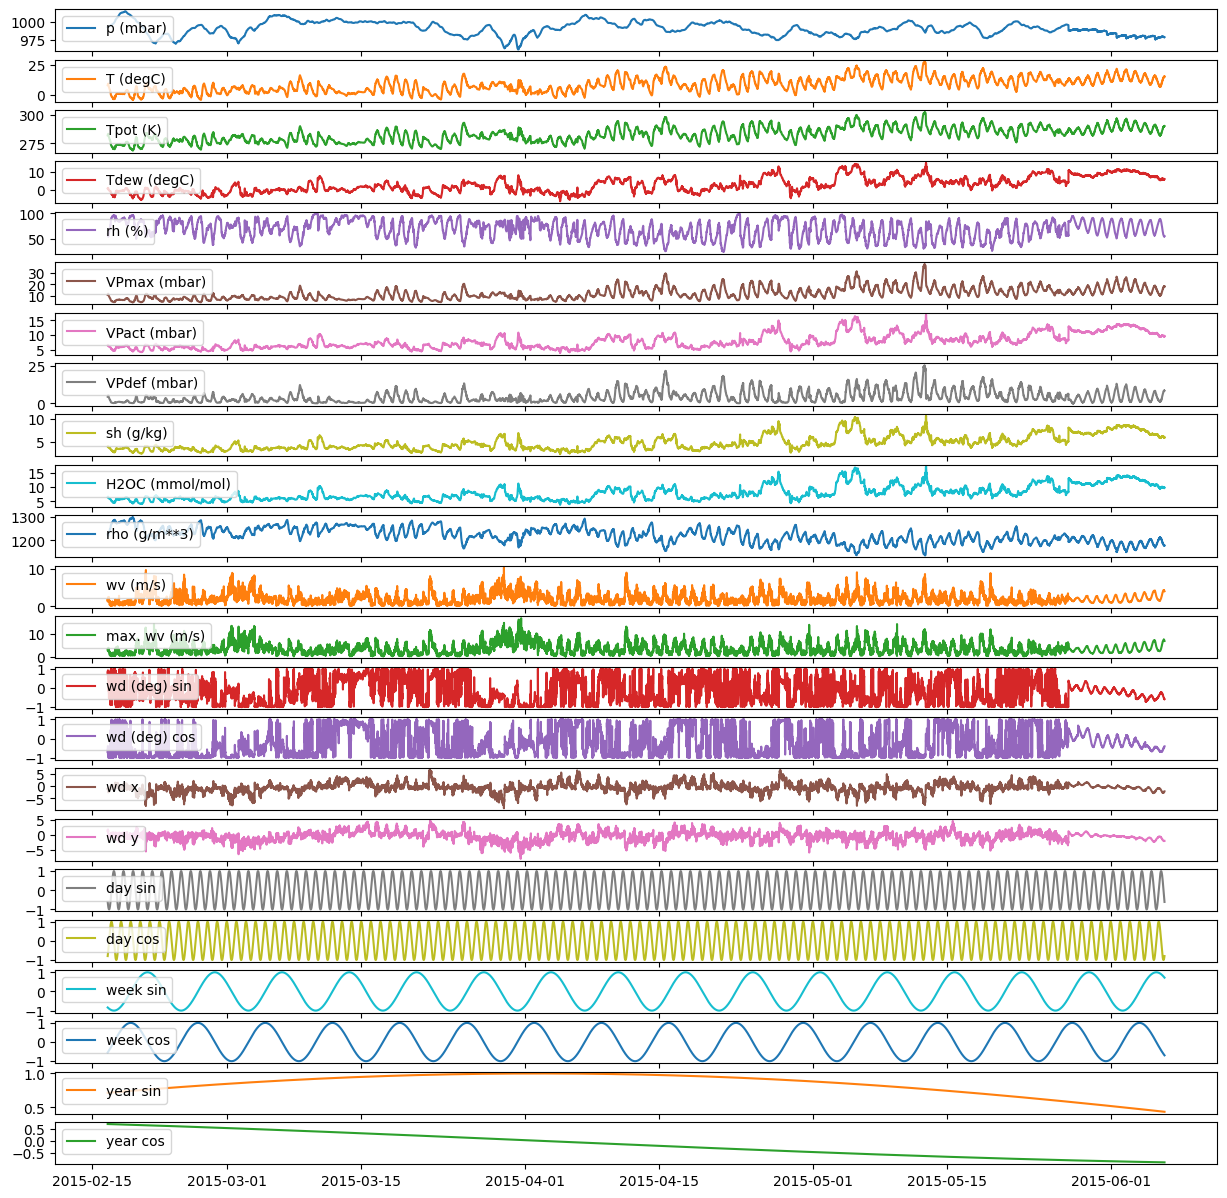

In [75]:
plot_df(before_after_pred_df * train_std + train_mean)

In [76]:
before_after_actual_df = pd.concat([train_df[-len(pred_df)*10:], val_df[0:1], val_df[1:(1+pred_steps*prediction_length)]])

In [77]:
before_after_actual_df.shape

(15841, 23)

In [78]:
assert before_after_pred_df.shape == before_after_actual_df.shape

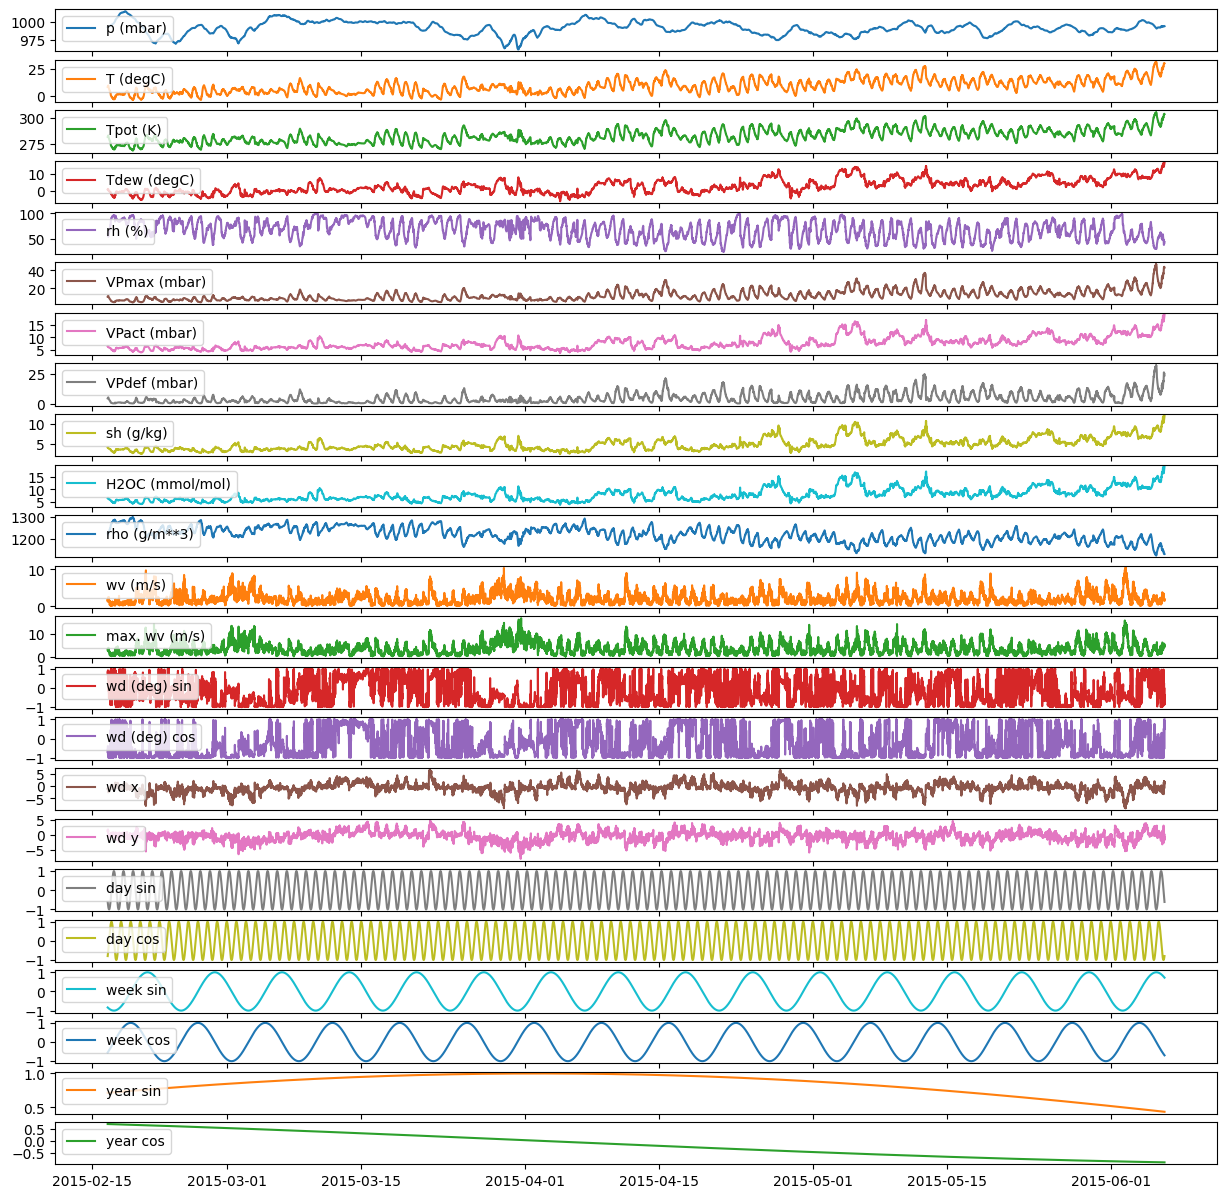

In [79]:
plot_df(before_after_actual_df * train_std + train_mean)

In [80]:
diff_df = before_after_pred_df - before_after_actual_df

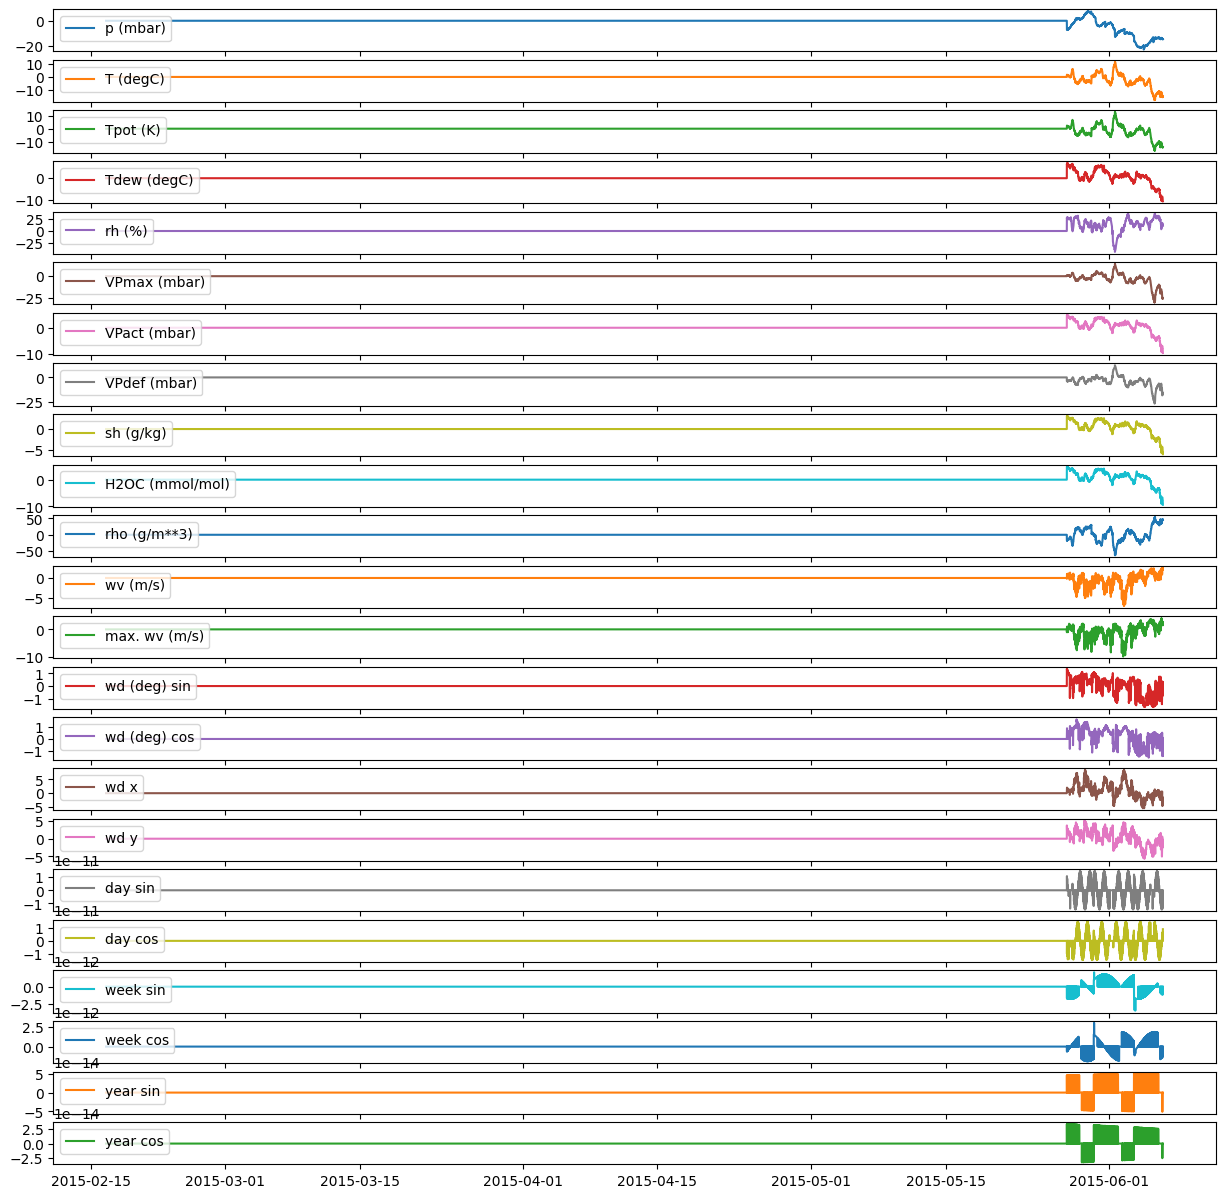

In [81]:
plot_df(diff_df * train_std)